In [48]:
from tabula.io import read_pdf
import pandas as pd
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

In [49]:
# Read PDF into a list of DataFrames
ldf = read_pdf(
    "https://storage.googleapis.com/wzukusers/user-34561429/documents/3331954838f84f9db46da46e1b0938db/0412-Public%20Sales%20List.pdf",
    pages='all')


In [50]:
print(f"Output is a {type(ldf)} of {type(ldf[0])}")

Output is a <class 'list'> of <class 'pandas.core.frame.DataFrame'>


In [51]:
# Combine list of data frames into 1 data frame
combined_df = pd.concat(ldf)

In [52]:
# Describe combined dataframe output
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 494 entries, 0 to 16
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BLOCK              494 non-null    float64
 1   LOT                494 non-null    float64
 2   QUALIFIER          25 non-null     object 
 3   CLASS              494 non-null    object 
 4   PROPERTY_LOCATION  494 non-null    object 
 5   YEARBUILT          494 non-null    int64  
 6   SFLA_TOTAL         494 non-null    object 
 7   SALE DATE          493 non-null    object 
 8   SALE PRICE         494 non-null    object 
 9   NUC                146 non-null    float64
dtypes: float64(3), int64(1), object(6)
memory usage: 42.5+ KB


In [53]:
# Data Cleaning
# remove row with no sale date
combined_df.dropna(subset=['SALE DATE'], inplace=True)
combined_df = combined_df[(combined_df['QUALIFIER'].isna()) & (combined_df['CLASS'] == '2')]

# Set feature to desired format
combined_df["SALE PRICE"] = combined_df["SALE PRICE"].str.replace('\\$|,', '', regex=True)
combined_df["SFLA_TOTAL"] = combined_df["SFLA_TOTAL"].str.replace(',', '')
# combined_df["NUC"] = combined_df["NUC"].replace(np.nan, '')
# combined_df["QUALIFIER"] = combined_df["QUALIFIER"].replace('NaN', '9999')
combined_df["CLASS"] = combined_df["CLASS"].str.strip()

combined_df = combined_df.astype({"BLOCK": 'str',
                                  "LOT": 'str',
                                  "NUC": 'str',
                                  "SALE PRICE": 'float',
                                  "SFLA_TOTAL": 'float',
                                  })
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 362 entries, 1 to 52
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BLOCK              362 non-null    object 
 1   LOT                362 non-null    object 
 2   QUALIFIER          0 non-null      object 
 3   CLASS              362 non-null    object 
 4   PROPERTY_LOCATION  362 non-null    object 
 5   YEARBUILT          362 non-null    int64  
 6   SFLA_TOTAL         362 non-null    float64
 7   SALE DATE          362 non-null    object 
 8   SALE PRICE         362 non-null    float64
 9   NUC                362 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 31.1+ KB


CLASS
2    362
Name: count, dtype: int64


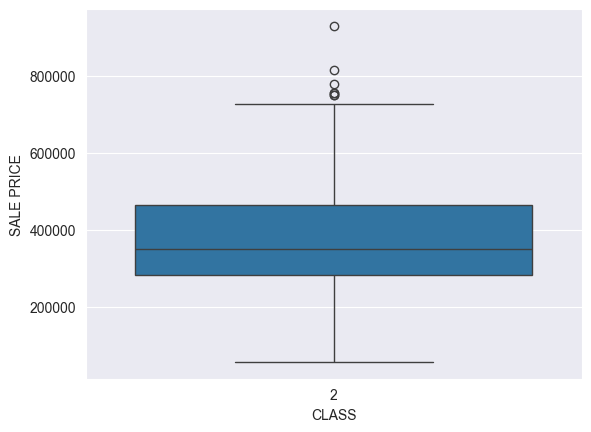

In [54]:
# Visualize target
sns.boxplot(x="CLASS",
            y="SALE PRICE",
            data=combined_df.reset_index())

print(combined_df.CLASS.value_counts())

In [55]:
# Re-inspect dataframe
combined_df.describe(include='all')

,BLOCK,LOT,QUALIFIER,CLASS,PROPERTY_LOCATION,YEARBUILT,SFLA_TOTAL,SALE DATE,SALE PRICE,NUC
count,362,362,0,362,362,362.000000,362.000000,362,362.00000,362
unique,135,109,0,1,362,NaN,NaN,275,NaN,11
top,1.07,10.0,NaN,2,230 S PARK DRIVE,NaN,NaN,7/15/2022,NaN,nan
freq,11,17,NaN,362,1,NaN,NaN,6,NaN,263
mean,NaN,NaN,NaN,NaN,NaN,1923.414365,1670.220994,NaN,384578.89779,NaN
std,NaN,NaN,NaN,NaN,NaN,16.928385,484.763718,NaN,146623.73276,NaN
min,NaN,NaN,NaN,NaN,NaN,1886.000000,830.000000,NaN,56800.00000,NaN
25%,NaN,NaN,NaN,NaN,NaN,1910.000000,1302.000000,NaN,282000.00000,NaN
50%,NaN,NaN,NaN,NaN,NaN,1922.000000,1580.000000,NaN,350000.00000,NaN
75%,NaN,NaN,NaN,NaN,NaN,1928.000000,1925.750000,NaN,464250.00000,NaN


In [56]:
# select predictors columns
predictors = ['YEARBUILT', 'SFLA_TOTAL', 'NUC']
target = 'SALE PRICE'

In [57]:
# Assuming df is your DataFrame
X = combined_df[predictors].values  #features
y = combined_df[target].values  # Target variable


In [58]:
# Check for and handle categorical variables
label_encoder = LabelEncoder()
x_categorical = combined_df[predictors].select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = combined_df[predictors].select_dtypes(exclude=['object'])
x_pred = pd.concat([x_numerical, x_categorical], axis=1).values

In [59]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=10, stop=1000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [60]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
regressor = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
regressor = RandomizedSearchCV(estimator=regressor,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=3,
                               verbose=2,
                               random_state=14,
                               n_jobs=-1)
# Fit the random search model
regressor.fit(x_pred, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 120, 230, 340, 450,
                                                         560, 670, 780, 890,
                                                         1000]},
                   random_state=14, verbose=2)

In [61]:
regressor.best_params_


{'n_estimators': 120,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

#### After all the parameter turning I ended up using mostly default parameter values, which gave better results. This might be dues to the small training data size

In [62]:
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=14, oob_score=True)

# Fit the regressor with x and y data
regressor.fit(x_pred, y)

RandomForestRegressor(n_estimators=10, oob_score=True, random_state=14)

In [63]:
# Access feature importances
importances = regressor.feature_importances_

# Create a dataframe to visualize feature importances
feature_importances = pd.DataFrame({'feature': predictors, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

print(feature_importances)

      feature  importance
1  SFLA_TOTAL    0.623347
0   YEARBUILT    0.249849
2         NUC    0.126804


In [64]:
# Evaluating the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# Making predictions on the same data or new data
predictions = regressor.predict(x_pred)

# Evaluating the model
mae = mean_absolute_error(y, predictions)
mape = mean_absolute_percentage_error(y, predictions)
mse = mean_squared_error(y, predictions)
print(f'Mean Absoluete Error: {mae}')
print(f'Mean Absolute Percent Error: {mape}')
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.044653446759525095
Mean Absoluete Error: 39766.598084036894
Mean Absolute Percent Error: 0.12071146226724687
Mean Squared Error: 3099255115.231014
R-squared: 0.8554393301121166


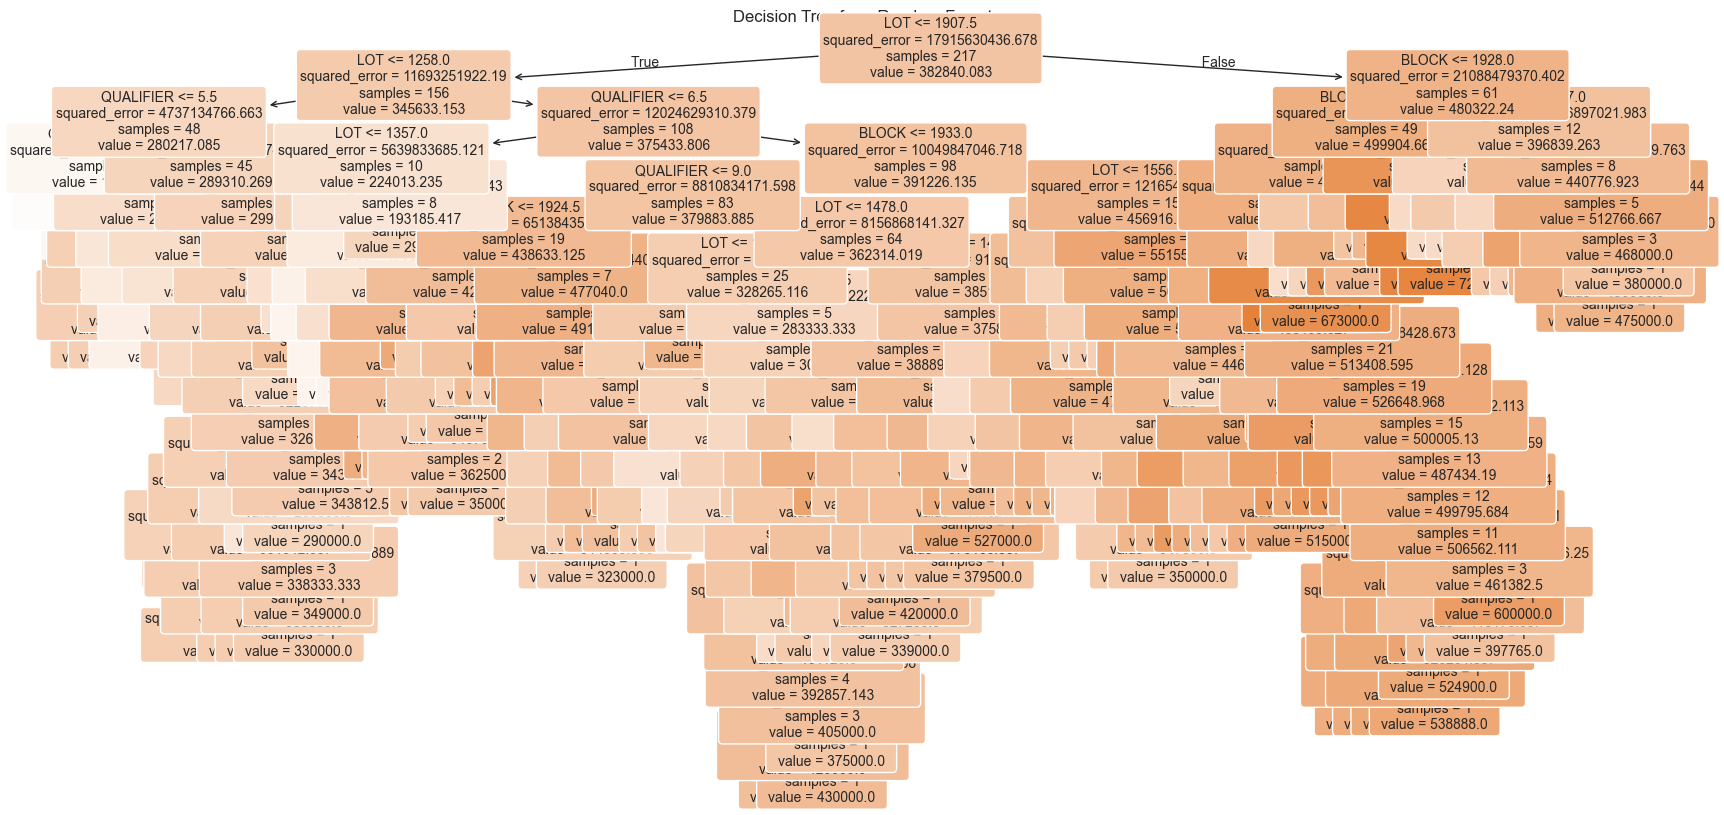

In [65]:
# Assuming regressor is your trained Random Forest model
# Pick one tree from the forest, e.g., the first tree (index 0)
tree_to_plot = regressor.estimators_[9]

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=combined_df.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

In [70]:
# What is the value of old home
x = [[1925, 1264, np.nan]]
regressor.predict(x)[0]

np.float64(345810.0)

![Local Image](images/CrestmontTer.png)

In [72]:
# What is the value of my new home
x = [[1900, 1992, np.nan]]
regressor.predict(x)[0]

np.float64(461600.0)

![Local Image](images/GormanAve.png)

# Clearly the training data is lacking recency since we just closed on the house in Jan 2025 but training data only included sale date up to Sept 2024